# Pawar et al. SFS Figures

#### Harrison Ostridge, 14/04/2022

This script makes the plots figures 2, S2, S3 and S4 for the manuscript. 

### Import modules

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.gridspec import GridSpec
import zarr
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import time
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.3.2


### Custom Functions

#### Data Manipulation Functions

In [2]:
def poly_filter(ac_subpops, rm_fixed_in_subsp=False, rmNCfixed=False):
    """Polymorphism filter: Remove sites which are not polymorphic in all the samples.
    There is also the option to remove sites which are fixed in the focal subspecies"""
    ac_subpops_filtered={}
    # Loop over subspecies
    for subsp in ac_subpops:
        # Remove sites which are not polymorphic when concidering all central, eastern and Nigeria-Cameroon
        mask=((ac_subpops['cen'][:,0]>0) & (ac_subpops['cen'][:,1]>0))
        # Remove sites fixed in the subspecies
        if rm_fixed_in_subsp==True:
            mask=(mask & (ac_subpops[subsp][:,0]>0) & (ac_subpops[subsp][:,1]>0))
        if rmNCfixed==True:
            mask=(mask & (ac_subpops['n'][:,0]>0) & (ac_subpops['n'][:,1]>0))
        # Also remove sites for which we do not know the ancestral allele
        ## These are codes with allele counts of -99999
        mask=(mask & (ac_subpops[subsp][:,0]>=0))
        # Apply mask
        ac_subpops_filtered[subsp]=ac_subpops[subsp].astype(float)
        ## Where the mask is False (i.e. we want to filter it out) -> replace with NA (hence the ~)
        ac_subpops_filtered[subsp][~mask,:]=np.nan
    return ac_subpops_filtered

def prep_ac_for_plotting(ac_list, subsps):
    """!!!ac_list must be in this order: "Whole genome", "0.5% tail", "0.1% tail", "0.05% tail"!!!
    NB: The dataframe produced isn't a proper dataframe in that each row does not 
    represent a SNP. It would be better represented as a list of vectors (because the 
    columns/vectors are different lengths) but I have coerced it into a dataframe for 
    ease of plotting."""
    all_ac_subsp={}
    for subsp in subsps:
        all_ac=pd.concat([pd.DataFrame(ac_list[0][subsp][:,1]), 
               pd.DataFrame(ac_list[1][subsp][:,1]), 
               pd.DataFrame(ac_list[2][subsp][:,1]), 
               pd.DataFrame(ac_list[3][subsp][:,1])], axis=1)
        all_ac.columns=["Whole genome", "0.5% tail", "0.1% tail", "0.05% tail"]

        all_ac_subsp[subsp]=all_ac
    return all_ac_subsp

def allele_frequency_difference(ac, pop1, pop2):
    """Calculates DAF of two populations and calculates the difference."""
    daf_1=ac[pop1][:,1]/(ac[pop1][:,0]+ac[pop1][:,1])
    daf_2=ac[pop2][:,1]/(ac[pop2][:,0]+ac[pop2][:,1])
    daf_diff=daf_1-daf_2
    daf_diff=pd.DataFrame(daf_diff)
    daf_diff.columns=["daf_diff"]
    return pd.DataFrame(daf_diff)

def polarise(ac, aa, ref, alt):
    """Polarise allele counts according to ancestral allele, reference allele and alternative allele.
    If the ancestral allele = the reference allele -> nothing changes (i.e. alternative allele count = derived allele count.
    If the ancestral allele = the alternative allele -> we need to swap things around.
    If the ancestral allele is not the reference or the alternative allele (or is unknown) -> replace count with invalid number (i.e. remove these sites)"""
    start_time = time.time()
    for subsp in ac:
        for snp in range(0,len(ac[subsp])):
            # If the ancestral allele = the reference allele -> nothing changes
            # If the ancestral allele = the alternative allele -> we need to swap things around
            ## NB: we are only dealing with biallicic sites (hence alt[snp,0] as this selects the first alternative allele)
            if aa[snp]==alt[snp,0]:
                aac=ac[subsp][snp,1]
                dac=ac[subsp][snp,0]
                # Insert correct values
                ac[subsp][snp,0]=aac
                ac[subsp][snp,1]=dac
            # If the ancestral allele is not the reference or the alternative allele (or is unknown)
            if (aa[snp]!=ref[snp]) and (aa[snp]!=alt[snp,0]):
                ac[subsp][snp,0]=(-99999)
                ac[subsp][snp,1]=(-99999)
        #print(subsp, " done", flush=True)
    print("--- %s seconds ---" % (time.time() - start_time))
    return(ac)

#### Plotting Functions

In [3]:
def plot_fig2(ac_all, af_diff_all, outfile='../output/figure2.pdf', 
                               ymax=0.02, abs_diff=True):
    from matplotlib.gridspec import GridSpec
    import matplotlib.pyplot as plt

    fig=plt.figure(figsize=(12,7))

    gs=GridSpec(3,2, width_ratios=[1,2]) # 3 rows, 2 columns

    ax0=fig.add_subplot(gs[0,0]) 
    ax1=fig.add_subplot(gs[1,0]) 
    ax2=fig.add_subplot(gs[2,0]) 
    ax3=fig.add_subplot(gs[:,1]) 

    colours=['grey','orange']
    tails=['Whole genome', '0.05% tail']
    xmax=1.01
    
    # Central
    for i in range(0,2):
        af=ac_all['c'][tails[i]]/sample_size['c']
        # Count frequncy of each DAC
        df=pd.DataFrame(af.value_counts())
        # Standardise by dividing by total number of observations (total number of SNPs)
        df[df.columns[0]]=df[df.columns[0]].div(df[df.columns[0]].sum())
        # Plot points 
        df.plot(y=df.columns[0], legend=True, ax=ax0, color=colours[i], marker='o', linestyle='none')
    ax0.set_title("A", loc='left', fontsize=18, fontweight="bold")
    ax0.text(.5,.85,'Central', horizontalalignment='center', transform=ax0.transAxes, fontsize=14)
    ax0.set_ylim([0, ymax])
    ax0.set_xlim([0.75, xmax])
    ax0.set_xticklabels([])
    ax0.set_ylabel("")
    ax0.get_legend().remove()

    # Eastern
    plot_list=[np.nan, np.nan, np.nan, np.nan]
    for i in range(0,2):
        af=ac_all['e'][tails[i]]/sample_size['e']
        # Count frequncy of each DAC
        df=pd.DataFrame(af.value_counts())
        # Standardise by dividing by total number of observations (total number of SNPs)
        df[df.columns[0]]=df[df.columns[0]].div(df[df.columns[0]].sum())
        # Plot points 
        df.plot(y=df.columns[0], legend=True, ax=ax1, color=colours[i], marker='o', linestyle='none')
    ax1.text(.5,.85,'Eastern', horizontalalignment='center', transform=ax1.transAxes, fontsize=14)
    ax1.set_ylim([0, ymax])
    ax1.set_xlim([0.75, xmax])
    ax1.set_xticklabels([])
    ax1.set_ylabel("Relative Frequency", fontsize=17)
    ax1.get_legend().remove()

    # Central and Eastern
    plot_list=[np.nan, np.nan, np.nan, np.nan]
    for i in range(0,2):
        af=ac_all['ce'][tails[i]]/sample_size['ce']
        # Count frequncy of each DAC
        df=pd.DataFrame(af.value_counts())
        # Standardise by dividing by total number of observations (total number of SNPs)
        df[df.columns[0]]=df[df.columns[0]].div(df[df.columns[0]].sum())
        # Plot points 
        df.plot(y=df.columns[0], legend=True, ax=ax2, color=colours[i], marker='o', linestyle='none')
    ax2.text(.5,.85,'Central and Eastern', horizontalalignment='center', transform=ax2.transAxes, fontsize=14)
    ax2.set_ylim([0, ymax])
    ax2.set_xlim([0.75, xmax])
    ax2.set_ylabel("")
    ax2.set_xlabel("Derived Allele Frequency", fontsize=17)
    ax2.get_legend().remove()

    # DAF differences
    plot_list=[np.nan, np.nan]
    if abs_diff:
        for i in range(0,2):
            plot_list[i]=np.absolute(af_diff_all[tails[i]])
        ax3.set_xlim([0, 1])
        ax3.set_xlabel("Allele Frequency Difference", fontsize=17)
    else:
        for i in range(0,2):
            plot_list[i]=af_diff_all[tails[i]]
        ax3.set_xlim([-1, 1])
        ax3.set_xlabel("Central-Eastern DAF - Nigeria-Cameroon DAF", fontsize=17)
    ax3.hist(plot_list, density=True,
             color=colours, bins=11, 
             alpha=1)
    ax3.set_title("B", loc='left', fontsize=18, fontweight="bold")
    ax3.set_ylabel("Density", fontsize=17)
    ax3.legend(['Whole genome', '0.05% tail'], loc='upper right', ncol=1, fontsize=14)
    
    plt.savefig(outfile)
    
def plot_figS3(ac_all, af_diff_all, outfile='../output/figureS3.pdf', 
                             ymax=0.02, abs_diff=True):
    from matplotlib.gridspec import GridSpec
    import matplotlib.pyplot as plt

    fig=plt.figure(figsize=(12,7))

    gs=GridSpec(3,2, width_ratios=[1,2]) # 3 rows, 2 columns

    ax0=fig.add_subplot(gs[0,0]) 
    ax1=fig.add_subplot(gs[1,0]) 
    ax2=fig.add_subplot(gs[2,0]) 
    ax3=fig.add_subplot(gs[:,1]) 

    colours=['grey', 'indigo', 'red','orange']

    xmax=1.01
    
    # Central
    for i in range(0,4):
        af=ac_all['c'][ac_all['c'].columns[i]]/sample_size['c']
        # Count frequncy of each DAC
        df=pd.DataFrame(af.value_counts())
        # Standardise by dividing by total number of observations (total number of SNPs)
        df[df.columns[0]]=df[df.columns[0]].div(df[df.columns[0]].sum())
        # Plot points 
        df.plot(y=df.columns[0], legend=True, ax=ax0, color=colours[i], marker='o', linestyle='none')
    ax0.set_title("A", loc='left', fontsize=18, fontweight="bold")
    ax0.text(.5,.85,'Central', horizontalalignment='center', transform=ax0.transAxes, fontsize=14)
    ax0.set_ylim([0, ymax])
    ax0.set_xlim([0.75, xmax])
    ax0.set_xticklabels([])
    ax0.set_ylabel("")
    ax0.get_legend().remove()

    # Eastern
    plot_list=[np.nan, np.nan, np.nan, np.nan]
    for i in range(0,4):
        af=ac_all['e'][ac_all['e'].columns[i]]/sample_size['e']
        # Count frequncy of each DAC
        df=pd.DataFrame(af.value_counts())
        # Standardise by dividing by total number of observations (total number of SNPs)
        df[df.columns[0]]=df[df.columns[0]].div(df[df.columns[0]].sum())
        # Plot points 
        df.plot(y=df.columns[0], legend=True, ax=ax1, color=colours[i], marker='o', linestyle='none')
    ax1.text(.5,.85,'Eastern', horizontalalignment='center', transform=ax1.transAxes, fontsize=14)
    ax1.set_ylim([0, ymax])
    ax1.set_xlim([0.75, xmax])
    ax1.set_xticklabels([])
    ax1.set_ylabel("Relative Frequency", fontsize=17)
    ax1.get_legend().remove()

    # Central and Eastern
    plot_list=[np.nan, np.nan, np.nan, np.nan]
    for i in range(0,4):
        af=ac_all['ce'][ac_all['ce'].columns[i]]/sample_size['ce']
        # Count frequncy of each DAC
        df=pd.DataFrame(af.value_counts())
        # Standardise by dividing by total number of observations (total number of SNPs)
        df[df.columns[0]]=df[df.columns[0]].div(df[df.columns[0]].sum())
        # Plot points 
        df.plot(y=df.columns[0], legend=True, ax=ax2, color=colours[i], marker='o', linestyle='none')
    ax2.text(.5,.85,'Central and Eastern', horizontalalignment='center', transform=ax2.transAxes, fontsize=14)
    ax2.set_ylim([0, ymax])
    ax2.set_xlim([0.75, xmax])
    ax2.set_ylabel("")
    ax2.set_xlabel("Derived Allele Frequency", fontsize=17)
    ax2.get_legend().remove()

    # DAF differences
    plot_list=[np.nan, np.nan, np.nan, np.nan]

    if abs_diff:
        for i in range(0,4):
            plot_list[i]=np.absolute(af_diff_all[af_diff_all.columns[i]])
        ax3.set_xlim([0, 1])
        ax3.set_xlabel("Allele Frequency Difference", fontsize=17)
    else:
        for i in range(0,4):
            plot_list[i]=af_diff_all[af_diff_all.columns[i]]
        ax3.set_xlim([-1, 1])
        ax3.set_xlabel("Central-Eastern DAF - Nigeria-Cameroon DAF", fontsize=17)
        
    ax3.hist(plot_list, density=True,
             color=colours, bins=11, 
             alpha=1)
    ax3.set_title("B", loc='left', fontsize=18, fontweight="bold")
    ax3.set_ylabel("Density", fontsize=17)
    ax3.legend(['Whole genome', '0.5% tail', '0.1% tail', '0.05% tail'], loc='upper right', ncol=1, fontsize=14)

    plt.savefig(outfile)
    
def figure_S2(ac_all, outfile='../output/figureS2.pdf', ymax=0.3):
    fig=plt.figure(figsize=(23,7))
    gs=GridSpec(1,3) # 2 rows, 2 columns
    ax={}
    ax['c']=fig.add_subplot(gs[0,0]) 
    ax['e']=fig.add_subplot(gs[0,1]) 
    ax['ce']=fig.add_subplot(gs[0,2]) 

    colours=['grey', 'indigo', 'red', 'orange']
    subsp_names={'c':'Central', 'e':'Eastern', 'ce':'Central and Eastern', 'n':'Nigeria-Cameroon'}
    # Plot
    for subsp in ['c', 'e', 'ce']:
        for i in range(0,4):
            # Count frequncy of each DAC
            df=pd.DataFrame(ac_all[subsp][ac_all[subsp].columns[i]].value_counts())
            # Standardise by dividing by total number of observations (total number of SNPs)
            df[df.columns[0]]=df[df.columns[0]].div(df[df.columns[0]].sum())
            # Plot points 
            df.plot(y=df.columns[0], legend=True, ax=ax[subsp], color=colours[i], marker='.', linestyle='none')
        ax[subsp].set_title(subsp_names[subsp]+" SFS", fontsize=20)
        ax[subsp].set_xlim([0, sample_size[subsp]])
        ax[subsp].set_ylim([0, ymax])
        ax[subsp].set_xlabel("Derived Allele Count", fontsize=20)
        ax[subsp].set_ylabel("Relative Frequency", fontsize=20)
        ax[subsp].legend(loc='upper right', ncol=1, fontsize=15)
    plt.savefig(outfile)


## Read and Format Data

Details of hpw these VCFs were made can be found in Pawar_et.al._candidate_vcfs.Rmd.

### Convert VCF to Zarr 

Only needs to be run once.

Zarr is a much more efficent and quicker way of accessing data in a VCF (http://alimanfoo.github.io/2017/06/14/read-vcf.html).

In [4]:
start_time = time.time()
# Whole genome
allel.vcf_to_zarr('../data/Clean_Callable_Pan_troglodytes_ALL_Concat_1M_HWE_gls_Hetexcess_EPO_AA_90.vcf.gz', '../data/Clean_Callable_Pan_troglodytes_ALL_Concat_1M_HWE_gls_Hetexcess_EPO_AA_90.zarr', overwrite=True, fields=['CHROM', 'POS', 'REF', 'ALT', 'AA', 'GT', 'samples'])

# Candidate windows
allel.vcf_to_zarr('../data/window_subset_0.5percent.vcf.gz', '../data/window_subset_0.5percent.zarr', overwrite=True, fields=['CHROM', 'POS', 'REF', 'ALT', 'AA', 'GT', 'samples'])
allel.vcf_to_zarr('../data/window_subset_0.1percent.vcf.gz', '../data/window_subset_0.1percent.zarr', overwrite=True, fields=['CHROM', 'POS', 'REF', 'ALT', 'AA', 'GT', 'samples'])
allel.vcf_to_zarr('../data/window_subset_0.05percent.vcf.gz', '../data/window_subset_0.05percent.zarr', overwrite=True, fields=['CHROM', 'POS', 'REF', 'ALT', 'AA', 'GT', 'samples'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.699562072753906e-05 seconds ---


### Read Zarr 

In [5]:
# Whole genome
callset_full = zarr.open_group('../data/Clean_Callable_Pan_troglodytes_ALL_Concat_1M_HWE_gls_Hetexcess_EPO_AA_90.zarr', mode='r')
# Candidate windows
callset_05 = zarr.open_group('../data/window_subset_0.5percent.zarr', mode='r')
callset_01 = zarr.open_group('../data/window_subset_0.1percent.zarr', mode='r')
callset_005 = zarr.open_group('../data/window_subset_0.05percent.zarr', mode='r')

### Make Genotype Array

In [6]:
gt_full=allel.GenotypeArray(callset_full['calldata/GT'])
gt_05=allel.GenotypeArray(callset_05['calldata/GT'])
gt_01=allel.GenotypeArray(callset_01['calldata/GT'])
gt_005=allel.GenotypeArray(callset_005['calldata/GT'])

### Divide into Subspecies

Need to remove Donald who is a second generation central-western hybrid but reported as a western.

In [7]:
samples=pd.DataFrame(callset_full['samples'])
subpops= {
    'c': samples[samples[0].str.startswith("Ptt-")].index.tolist(),
    'e': samples[samples[0].str.startswith("Pts-")].index.tolist(),
    'n': samples[samples[0].str.startswith("Pte-")].index.tolist(),
    'w': samples[(samples[0].str.startswith("Ptv-") == True) & 
                 (samples[0].str.contains("Ptv-M-9730_Donald") == False)].index.tolist(),
    'ce': samples[samples[0].str.startswith(("Ptt-", "Pts-"))].index.tolist(),
    'cen': samples[samples[0].str.startswith(("Ptt-", "Pts-", "Pte-"))].index.tolist(),
}

### Get Allele Counts

In [8]:
ac_full = gt_full.count_alleles_subpops(subpops, max_allele=1) #max_allele=1 restricts to biallelic (index of 1 means two alleles)
ac_05 = gt_05.count_alleles_subpops(subpops, max_allele=1)
ac_01 = gt_01.count_alleles_subpops(subpops, max_allele=1)
ac_005 = gt_005.count_alleles_subpops(subpops, max_allele=1)

### Get Sample Sizes

In [9]:
sample_size={}
for subsp in ac_full:
    sample_size[subsp]=ac_full[subsp].max()

### Polarise

Extract the ancestral (AA), reference (REF) and alternative (ALT) allele per SNP. Until now the allele counts have corresponded to reference and alternative allele counts. Here I use the ancestral states from the EPO alignment to polarise the data giving ancestral and derived allele counts.

In [10]:
aa_full=np.array(callset_full['variants/AA'])
aa_05=np.array(callset_05['variants/AA'])
aa_01=np.array(callset_01['variants/AA'])
aa_005=np.array(callset_005['variants/AA'])

ref_full=np.array(callset_full['variants/REF'])
ref_05=np.array(callset_05['variants/REF'])
ref_01=np.array(callset_01['variants/REF'])
ref_005=np.array(callset_005['variants/REF'])

alt_full=np.array(callset_full['variants/ALT'])
alt_05=np.array(callset_05['variants/ALT'])
alt_01=np.array(callset_01['variants/ALT'])
alt_005=np.array(callset_005['variants/ALT'])

In [11]:
dac_full=polarise(ac_full, aa_full, ref_full, alt_full)
dac_05=polarise(ac_05, aa_05, ref_05, alt_05)
dac_01=polarise(ac_01, aa_01, ref_01, alt_01)
dac_005=polarise(ac_005, aa_005, ref_005, alt_005)

--- 244.90220594406128 seconds ---
--- 13.011147022247314 seconds ---
--- 2.058661699295044 seconds ---
--- 0.9340667724609375 seconds ---


We loose 4% of sites as we don't know their ancestral state (or in rare cases where the AA is known but != REF or ALT at triallelic sites).

## Figure 2 and S3

Same site filters as before in the original manuscript, all I change is the polarisation of frequencies.
    
**Alleles** - Derived allele frequencies (using EPO alignment).

**Site Filter** - Only sites which are polymorphic when central, eastern and Nigeria-Cameroon are concidered (i.e. remove variants pivate to western)

### Polymorphism Filter

In [12]:
dac_full_PF_cen=poly_filter(dac_full, rm_fixed_in_subsp=False, rmNCfixed=False)
dac_05_PF_cen=poly_filter(dac_05, rm_fixed_in_subsp=False, rmNCfixed=False)
dac_01_PF_cen=poly_filter(dac_01, rm_fixed_in_subsp=False, rmNCfixed=False)
dac_005_PF_cen=poly_filter(dac_005, rm_fixed_in_subsp=False, rmNCfixed=False)

### Format Data for Plotting

In [13]:
dac_all_PF_cen=prep_ac_for_plotting(ac_list=[dac_full_PF_cen, dac_05_PF_cen, dac_01_PF_cen, dac_005_PF_cen],
                            subsps=['c', 'e', 'ce', 'n'])

### Calculate the Allele Frequency Difference Between the Central-Eastern Clade and Nigeria-Cameroon 

In [14]:
daf_diff_full_PF_cen=allele_frequency_difference(dac_full_PF_cen, pop1="ce", pop2="n")
daf_diff_05_PF_cen=allele_frequency_difference(dac_05_PF_cen, pop1="ce", pop2="n")
daf_diff_01_PF_cen=allele_frequency_difference(dac_01_PF_cen, pop1="ce", pop2="n")
daf_diff_005_PF_cen=allele_frequency_difference(dac_005_PF_cen, pop1="ce", pop2="n")
# Combine tables so they can be plotted together 
daf_diff_all_PF_cen=pd.concat([pd.DataFrame(daf_diff_full_PF_cen), 
               pd.DataFrame(daf_diff_05_PF_cen), 
               pd.DataFrame(daf_diff_01_PF_cen), 
               pd.DataFrame(daf_diff_005_PF_cen)], axis=1)
daf_diff_all_PF_cen.columns=["Whole genome", "0.5% tail", "0.1% tail", "0.05% tail"]

<ipython-input-2-3bdcf56ec09f>:42: RuntimeWarning: invalid value encountered in true_divide
  daf_1=ac[pop1][:,1]/(ac[pop1][:,0]+ac[pop1][:,1])
<ipython-input-2-3bdcf56ec09f>:43: RuntimeWarning: invalid value encountered in true_divide
  daf_2=ac[pop2][:,1]/(ac[pop2][:,0]+ac[pop2][:,1])


### Plot

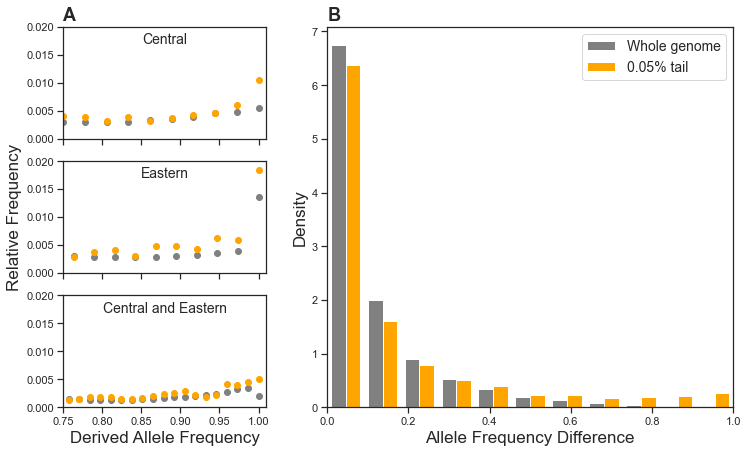

In [15]:
plot_fig2(dac_all_PF_cen, daf_diff_all_PF_cen)

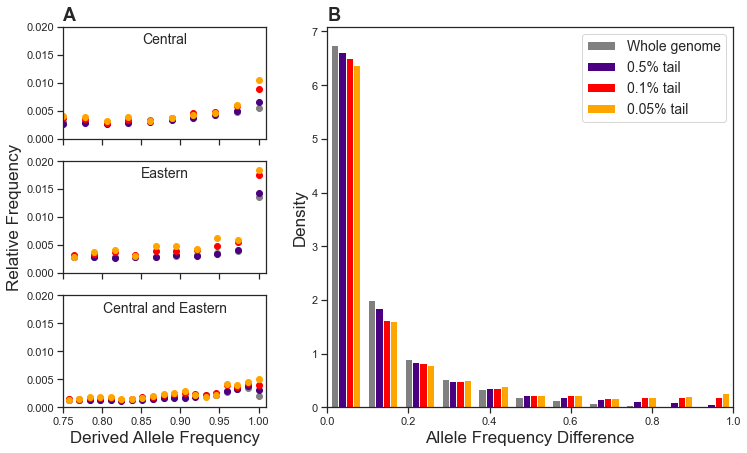

In [16]:
plot_figS3(dac_all_PF_cen, daf_diff_all_PF_cen)

## Figure S2: Full SFS


**Alleles** - Derived allele frequencies (using EPO alignment).

**Site Filter** - Only sites which are polymorphic in the subspecies in question.

- i.e. if a site is fixed in central (but polymorphic in eastern and Nigeria-Cameroon) this site will be removed from the central data but remain in the data for the other subspecies.

- This is because a true SFS should only show the frequency of segragating alleles.

### Polymorphism Filter

In [17]:
dac_full_PF_c_e_n=poly_filter(dac_full, rm_fixed_in_subsp=True, rmNCfixed=False)
dac_05_PF_c_e_n=poly_filter(dac_05, rm_fixed_in_subsp=True, rmNCfixed=False)
dac_01_PF_c_e_n=poly_filter(dac_01, rm_fixed_in_subsp=True, rmNCfixed=False)
dac_005_PF_c_e_n=poly_filter(dac_005, rm_fixed_in_subsp=True, rmNCfixed=False)

### Format Data for Plotting

In [18]:
dac_all_PF_c_e_n=prep_ac_for_plotting(ac_list=[dac_full_PF_c_e_n, dac_05_PF_c_e_n, dac_01_PF_c_e_n, dac_005_PF_c_e_n],
                            subsps=['c', 'e', 'ce', 'n'])

### Plot

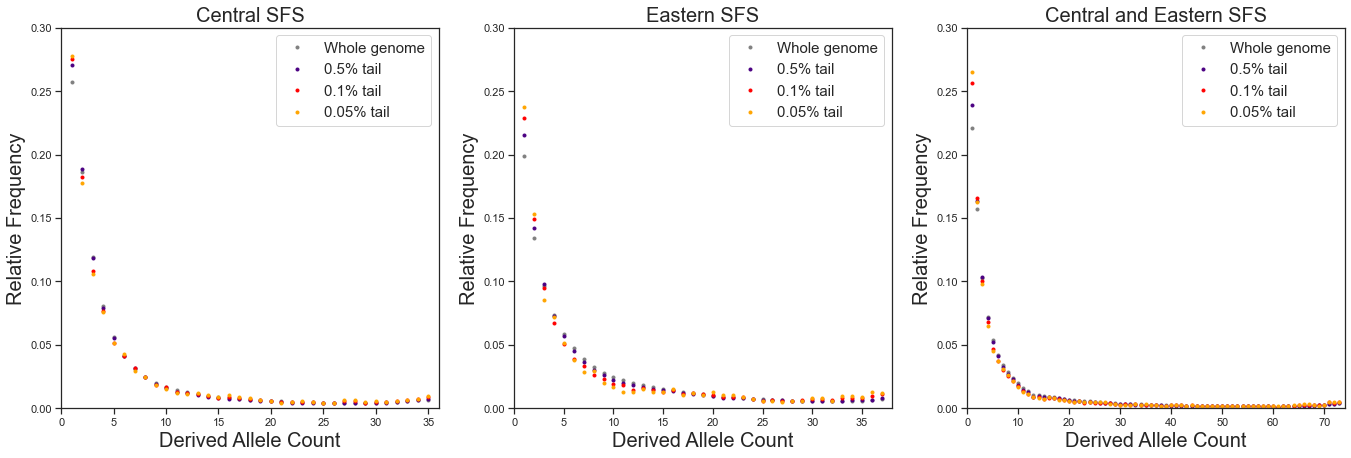

In [19]:
figure_S2(dac_all_PF_c_e_n)

## Figure S4: Individual SNP DAFs

**Alleles** - Derived allele frequencies (using EPO alignment).

**Site Filter** - I extract specific SNPs, no additional filters.

### Read Zarr 

In [20]:
# Candidate windows
callset_05 = zarr.open_group('../data/window_subset_0.5percent.zarr', mode='r')

### Make Genotype Array

In [21]:
gt_05=allel.GenotypeArray(callset_05['calldata/GT'])

### Divide into Subspecies

Need to remove Donald who is a second generation central-western hybrid but reported as a western.

In [22]:
samples=pd.DataFrame(callset_full['samples'])
subpops= {
    'c': samples[samples[0].str.startswith("Ptt-")].index.tolist(),
    'e': samples[samples[0].str.startswith("Pts-")].index.tolist(),
    'n': samples[samples[0].str.startswith("Pte-")].index.tolist(),
    'w': samples[(samples[0].str.startswith("Ptv-") == True) & 
                 (samples[0].str.contains("Ptv-M-9730_Donald") == False)].index.tolist(),
    'ce': samples[samples[0].str.startswith(("Ptt-", "Pts-"))].index.tolist(),
    'cen': samples[samples[0].str.startswith(("Ptt-", "Pts-", "Pte-"))].index.tolist(),
}

### Get Allele Counts

In [23]:
ac_05 = gt_05.count_alleles_subpops(subpops, max_allele=1)

### Polarise

In [24]:
aa_05=np.array(callset_05['variants/AA'])
ref_05=np.array(callset_05['variants/REF'])
alt_05=np.array(callset_05['variants/ALT'])

In [25]:
dac_05=polarise(ac_05, aa_05, ref_05, alt_05)

--- 13.695044040679932 seconds ---


### Get genomic coordinates 

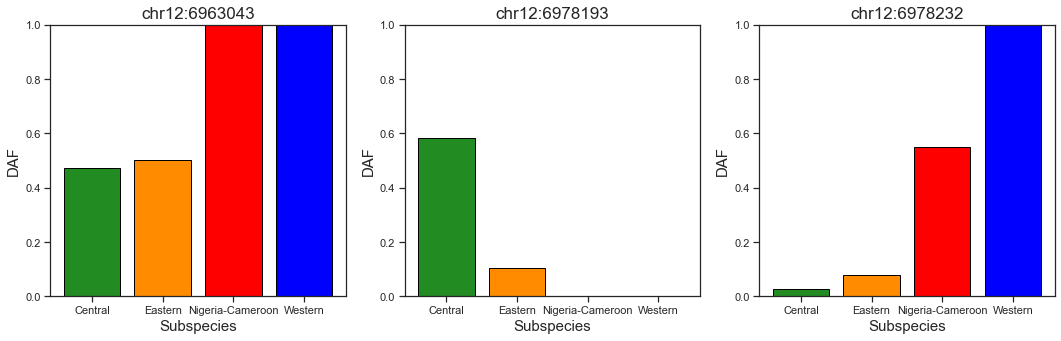

In [26]:
snp_chr=np.array(callset_05['variants/CHROM'])
snp_pos=np.array(callset_05['variants/POS'])

# These are SNPs of interest in CD4
snps=[['12', 6963043],
     ['12', 6978193],
     ['12', 6978232]]
subsps=['c', 'e', 'n', 'w']
subspecies=['Central', 'Eastern', 'Nigeria-Cameroon', 'Western']

# Plot
fig=plt.figure(figsize=(18,5))
gs=GridSpec(1,3) # 3 rows, 1 column

ax={}
ax[1]=fig.add_subplot(gs[0,0]) 
ax[2]=fig.add_subplot(gs[0,1]) 
ax[3]=fig.add_subplot(gs[0,2]) 
for i in range(0, len(snps)):
    snp=snps[i]
    chromo=snp[0]
    pos=snp[1]
    snp_daf=[]
    # Calculate DAF for each subspecies
    for subsp in subsps:
        # Select the SNP
        snp_subsp_ac=dac_05[subsp][(snp_chr==chromo) & (snp_pos==pos)]
        # Derived allele count/total allele count = DAF
        snp_subsp_daf=snp_subsp_ac[0][1]/(snp_subsp_ac[0][1]+snp_subsp_ac[0][0])
        # Add DAF for this subspecies to results
        snp_daf.append(snp_subsp_daf)
    # Plot DAFs per subspecies
    colours=['forestgreen', 'darkorange','red','blue']
    ## i+1 is because I cannot assign somthing to ax[0]
    ax[i+1].bar(subspecies, snp_daf, color=colours, edgecolor='black')
    ax[i+1].set_ylim([0, 1])
    ax[i+1].set_ylabel("DAF", fontsize=15)
    ax[i+1].set_xlabel("Subspecies", fontsize=15)
    ax[i+1].set_title("chr"+chromo+":"+str(pos), fontsize=17)
    
plt.savefig('../output/figureS5.pdf')
plt.show()